<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ice Vision 0.5.1 (Detección)

## Librerías

In [1]:
%%capture
!pip install fastai --upgrade

In [2]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

In [1]:
from fastai.vision.all import *

In [2]:
from icevision.all import *

In [3]:
from matplotlib import pyplot as plt
import cv2
import json
import os
import re

In [4]:
%%capture
!unzip dataset.zip

## Parser
Para archivos .json (también vale para .txt) que contengan información de la forma:

  [{'bbox' : [xmin,ymin,xmax,ymax], 'label' : nombre},{},...]

In [5]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [6]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [7]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          if fichero.name!='.ipynb_checkpoints':
            yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.jpg")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.jpg")

    def labels(self, o) -> List[int]:
      d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32,'3x8':33,'2x2':34}
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for L in anotacion:
        label.append(d[L['label']])
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for L in anotacion:
        bbox.append(BBox.from_xyxy(L['box'][0],L['box'][1],L['box'][2],L['box'][3]))
      return bbox

- **train parser**

In [8]:
anot = AnotacionParser('dataset/train/images','dataset/train/annotations')

- **test parser**

In [9]:
anot_test = AnotacionParser('dataset/test/images','dataset/test/annotations')

## Records

In [10]:
%%capture
train_rs, valid_rs = anot.parse()
test_rs,_=anot_test.parse(RandomSplitter((1, 0)))

INFO     - Autofixing records | icevision.parsers.parser:parse:126


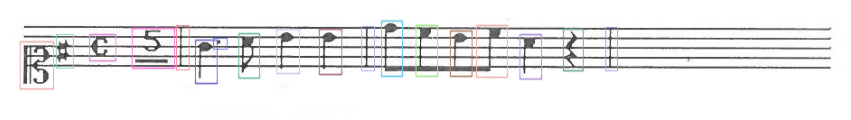

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 20))
show_record(train_rs[23], display_label=False,ax=ax)

In [12]:
len(train_rs)/(len(train_rs)+len(valid_rs))

0.7974137931034483

## Modelos

### FasterRCNN

In [ ]:
class ReduceLRMAP(fastai.ReduceLROnPlateau):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,factor=factor,min_lr=min_lr,
                     reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False

    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = self.opt.hypers[-1]['lr']
        for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
        self.wait = 0
        if self.opt.hypers[-1]["lr"] < old_lr:
          print(f'Epoch {self.epoch}: reducing lr to {self.opt.hypers[-1]["lr"]}')


def compareM(x1,x2):
  if isinstance(x1,dict):
    x1=float(x1['mAP'])
  if isinstance(x2,dict):
    x2=float(x2['mAP'])
  return np.greater(x1,x2)

In [ ]:
model = faster_rcnn.model(num_classes=35)

In [ ]:
presize = 926
size = 926

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

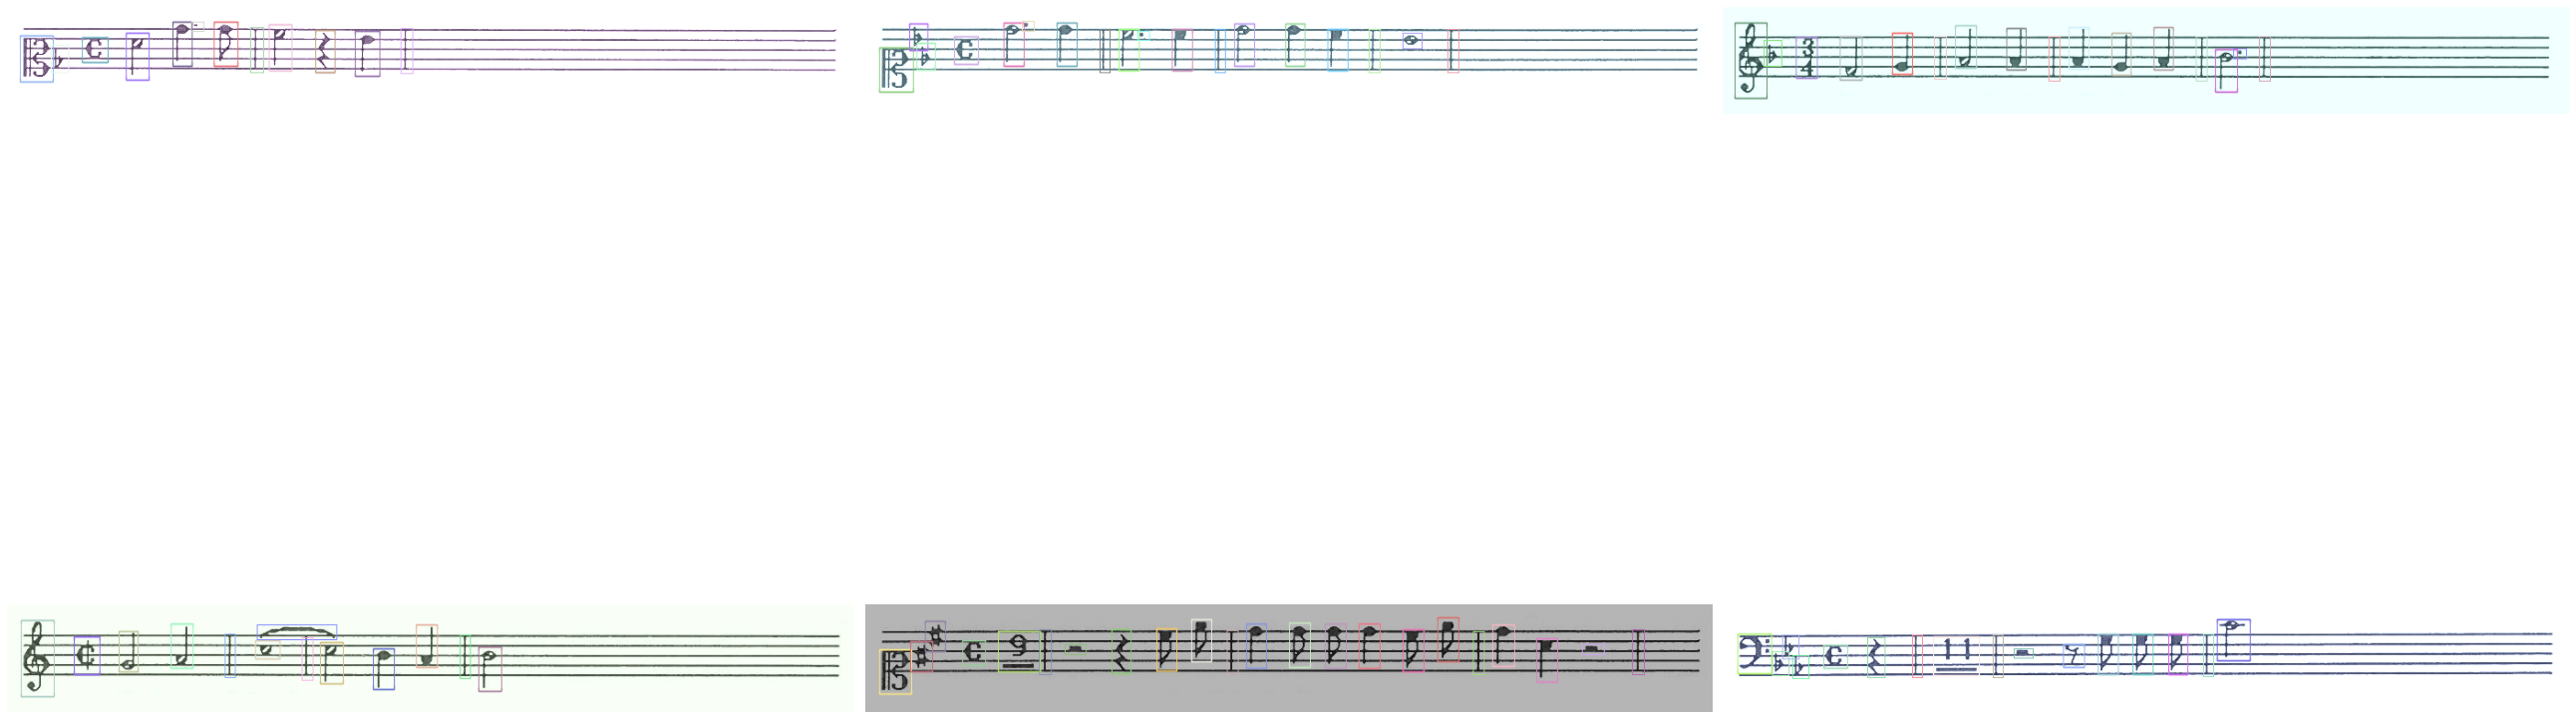

In [ ]:
samples = [train_ds[i] for i in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

In [ ]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
saveM=SaveModelCallback(monitor='COCOMetric',fname='FasterRCMM',comp=compareM)
lrReduce=ReduceLRMAP(monitor='COCOMetric',patience=3, factor=10.0, min_lr=0,comp=compareM)
early=EarlyStoppingCallback(monitor='COCOMetric',patience=3,comp=compareM)

In [ ]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=[saveM,lrReduce,early])

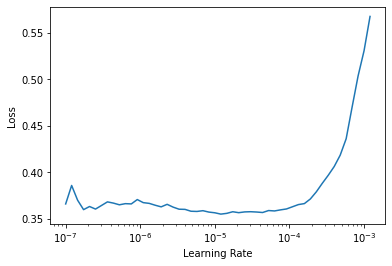

In [ ]:
print(learn.recorder.metrics)
(min_lr,steep)=learn.lr_find(show_plot=True)

Observar que lleva bastante tiempo entrenar el modelo. EL dataset cuenta con unas 300 imágenes de las cuales el 75 % pertenecen a el conjunto de train. Hay que tener en cuenta que al aumentar el dataset, el tiempo de entrenamiento va a ser más largo (y puede que no consigamos mejorar los resultados).

In [ ]:
learn.fine_tune(50,min_lr, freeze_epoch=2)

In [ ]:
torch.save(model.state_dict(),'mejor.pth')

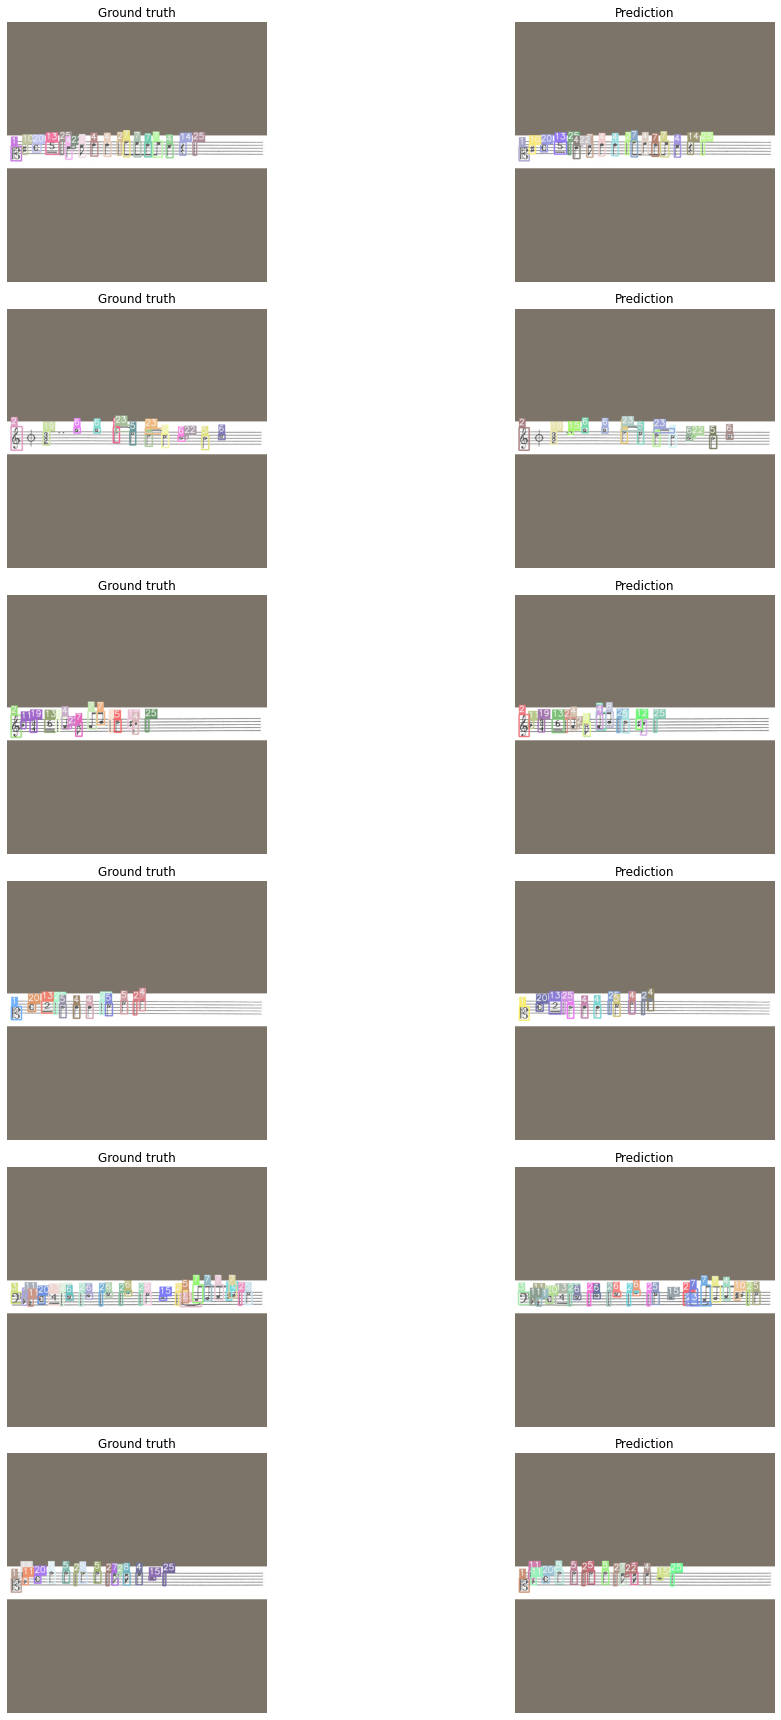

In [ ]:
faster_rcnn.show_results(model, valid_ds)

#### Inferencia en conjunto de test

In [ ]:
state_dict = torch.load('mejor.pth')
model = faster_rcnn.model(num_classes=35)

In [ ]:
model.load_state_dict(state_dict)

In [ ]:
test1=cv2.imread('/content/dataset/test/images/pent189.jpg')
test2=cv2.imread('/content/dataset/test/images/pent280.jpg')
test3=cv2.imread('/content/dataset/test/images/super_mario_theme7.jpg') # Esta funcionará peor ya que es de otra clase

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=600), tfms.A.Normalize()])
infer_ds = Dataset.from_images([test1,test2,test3], infer_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

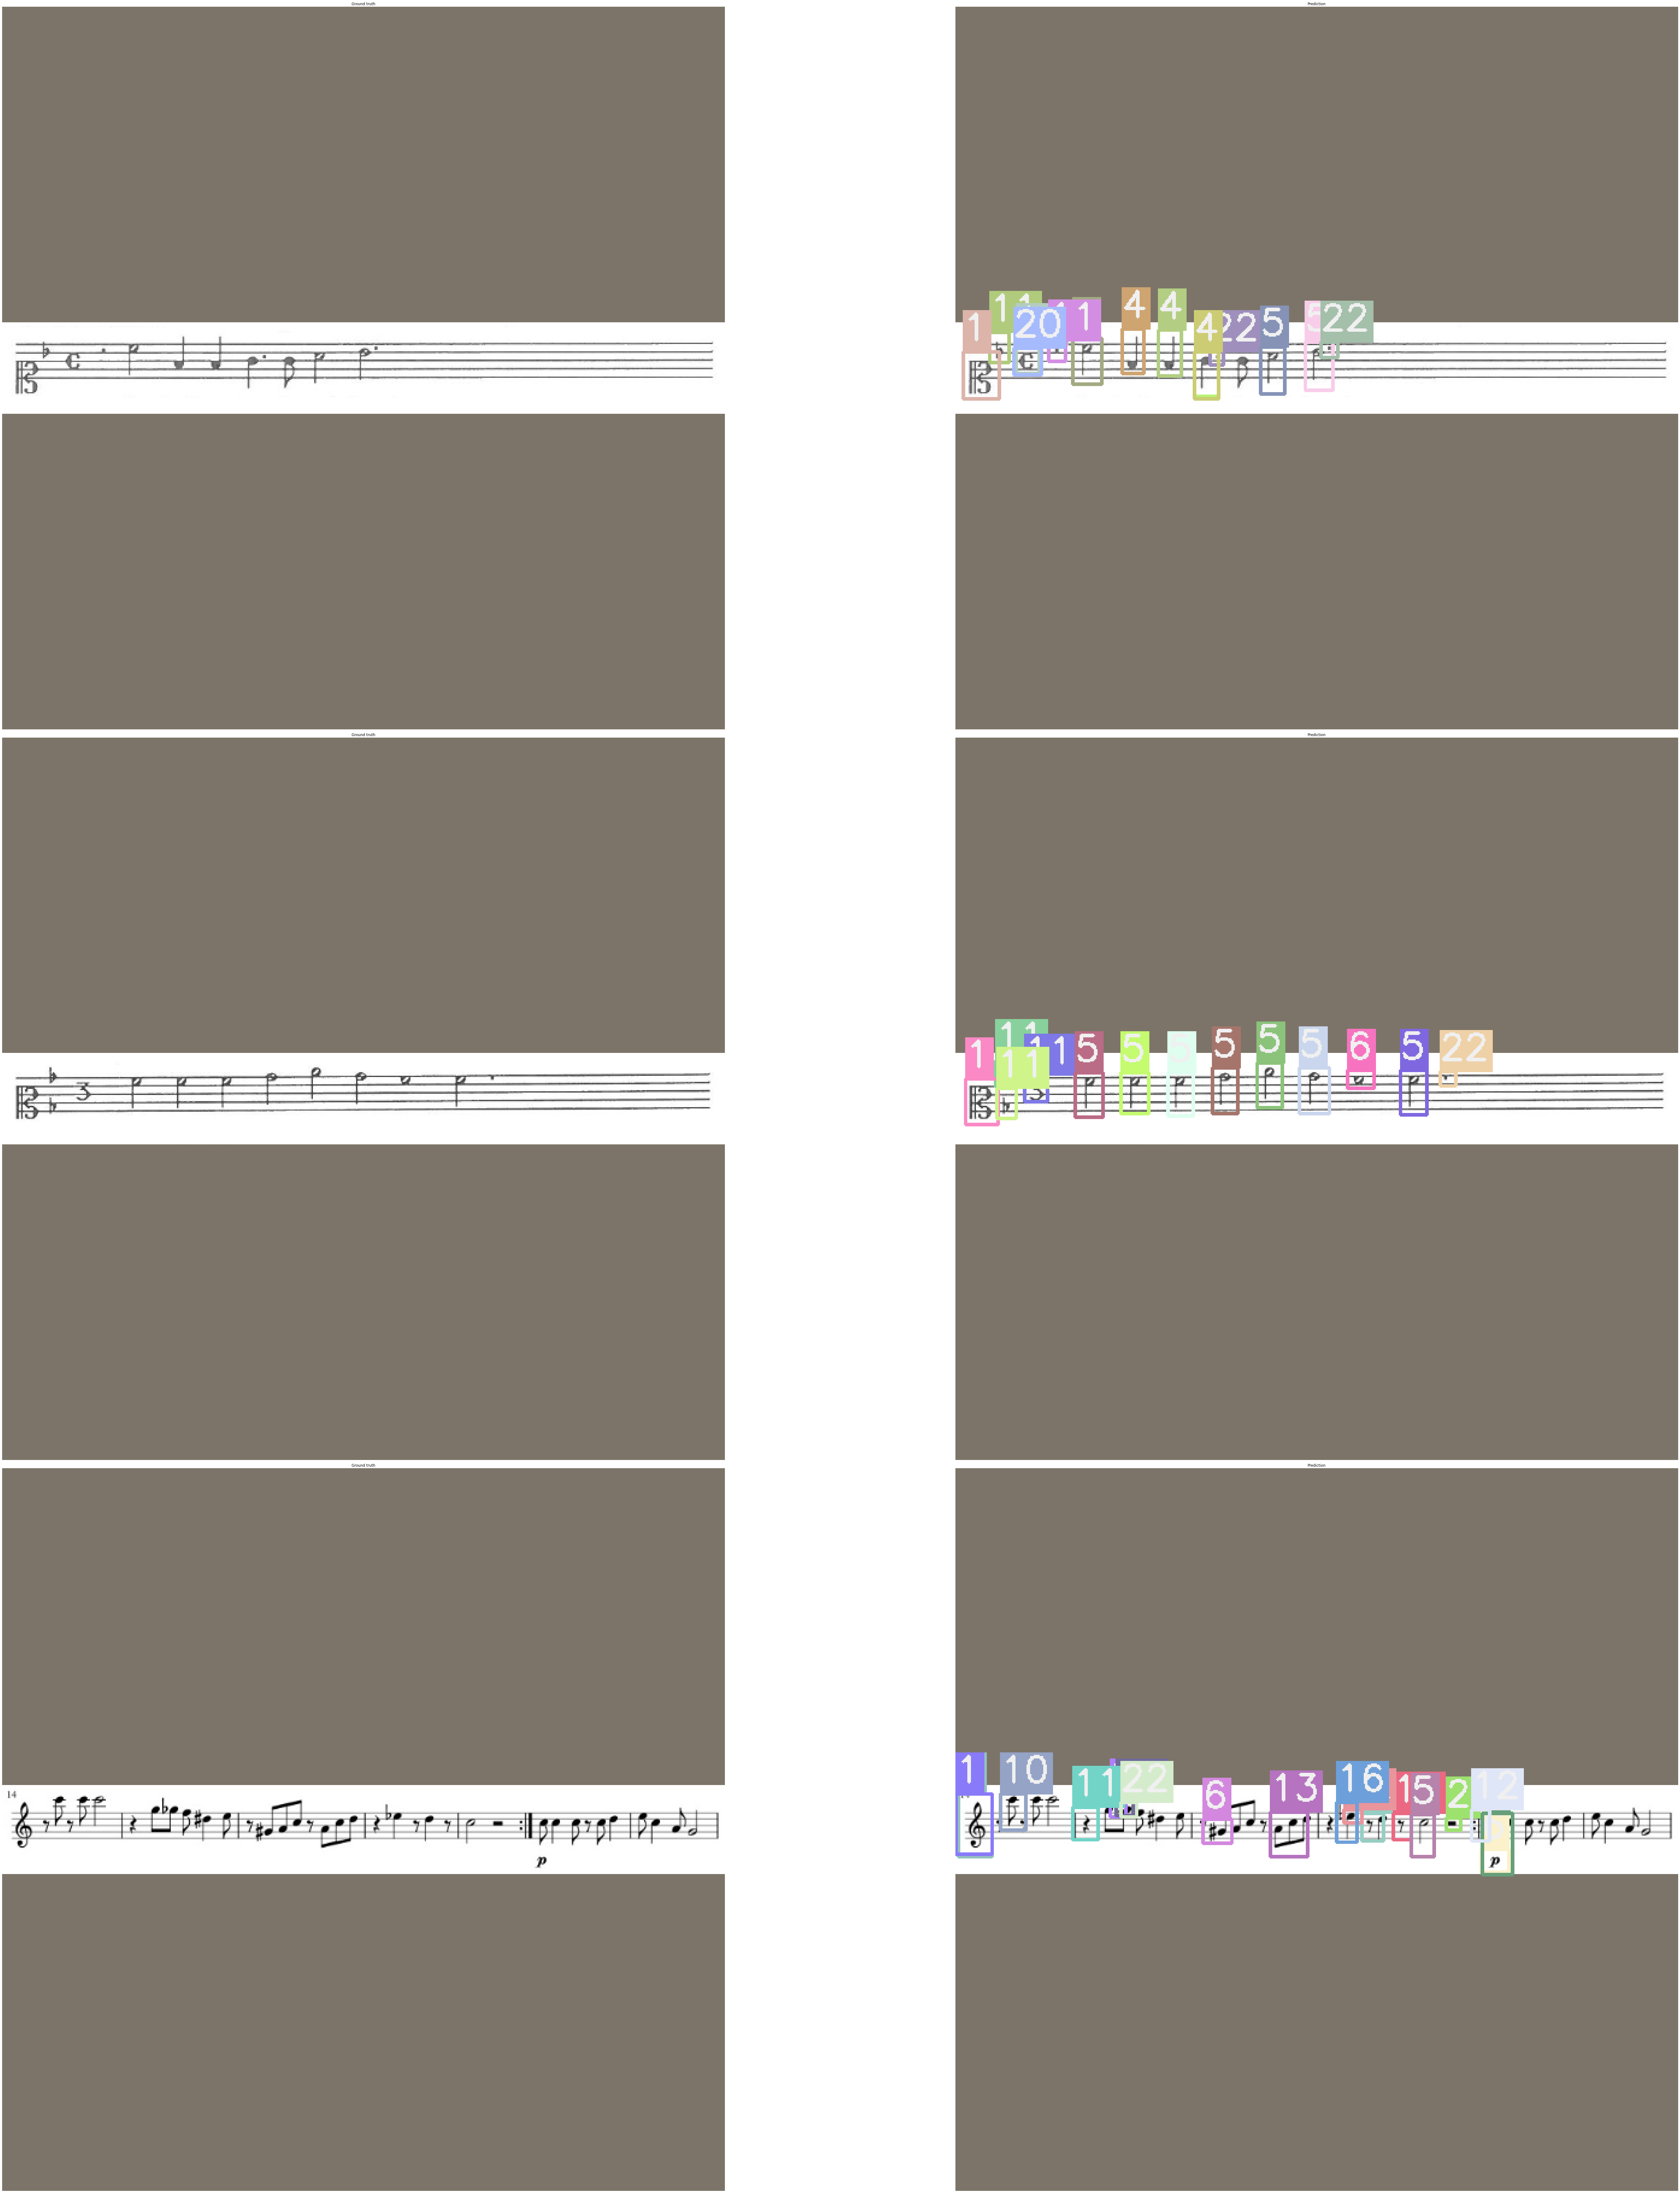

In [ ]:
show_preds(samples=samples, preds=preds,denormalize_fn=denormalize_imagenet,figsize=(100,100))

#### Resultado final en conjunto de test

In [ ]:
state_dict = torch.load('mejor.pth')
model = faster_rcnn.model(num_classes=35)

In [ ]:
model.load_state_dict(state_dict)

In [ ]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

In [ ]:
test_ds = Dataset(test_rs, valid_tfms)
test_dl = faster_rcnn.valid_dl(test_ds, batch_size=2, num_workers=0, shuffle=False)

In [ ]:
newdl = fastai.DataLoaders(faster_rcnn.fastai.convert_dataloader_to_fastai(train_dl),faster_rcnn.fastai.convert_dataloader_to_fastai(test_dl)).to('cuda')

In [ ]:
learn.dls = newdl
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5935895458422508.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.5149908065795898,0.5935895458422508]

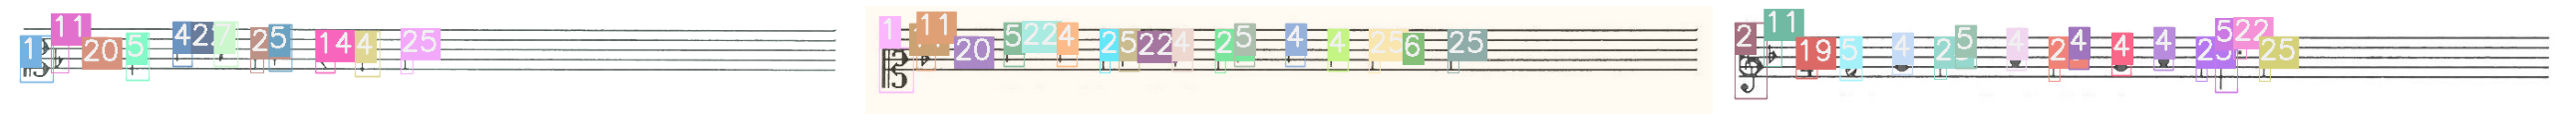

In [ ]:
samples = [newdl.dataset[i] for i in range(3)]
show_samples(samples, ncols=3,denormalize_fn=denormalize_imagenet)

- **COCO metric en conjunto de test: 0.5936**

### EfficientNet

In [ ]:
presize = 1024
size = 512

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None, horizontal_flip=None), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

In [ ]:
train_dl = efficientdet.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)

In [ ]:
callbacks = [EarlyStoppingCallback(patience=3),SaveModelCallback(fname='modelEfficientDet'),ReduceLROnPlateau(patience=2) ]

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
model = efficientdet.model(model_name="tf_efficientdet_d3", num_classes=35, img_size=size)

In [ ]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

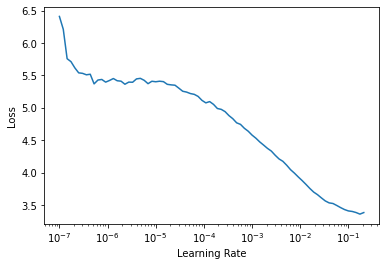

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500, step, freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,3.324376,2.153119,0.011039,00:30
1,2.319021,1.679842,0.001394,00:29


Better model found at epoch 0 with valid_loss value: 2.1531193256378174.
Better model found at epoch 1 with valid_loss value: 1.6798415184020996.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,1.189866,1.472616,0.010638,00:34
1,1.080064,0.936410,0.037602,00:33
2,0.996074,0.755205,0.054931,00:33
3,0.894553,0.732327,0.055877,00:33
4,0.845762,0.698265,0.060929,00:34
5,0.796481,0.532904,0.089080,00:34
6,0.780119,0.541030,0.084883,00:33
7,0.717088,0.516104,0.098836,00:33
8,0.692619,0.473520,0.106538,00:34
9,0.655023,0.461433,0.113253,00:34


Better model found at epoch 0 with valid_loss value: 1.4726158380508423.
Better model found at epoch 1 with valid_loss value: 0.9364103078842163.
Better model found at epoch 2 with valid_loss value: 0.7552047371864319.
Better model found at epoch 3 with valid_loss value: 0.7323271632194519.
Better model found at epoch 4 with valid_loss value: 0.6982649564743042.
Better model found at epoch 5 with valid_loss value: 0.5329044461250305.
Better model found at epoch 7 with valid_loss value: 0.5161043405532837.
Better model found at epoch 8 with valid_loss value: 0.47352004051208496.
Better model found at epoch 9 with valid_loss value: 0.46143317222595215.
Better model found at epoch 10 with valid_loss value: 0.4458838999271393.
Better model found at epoch 12 with valid_loss value: 0.4251694977283478.
Epoch 14: reducing lr to 5.7589657501962944e-05
Better model found at epoch 15 with valid_loss value: 0.3924456834793091.
Epoch 17: reducing lr to 5.981782652794886e-05
Better model found at ep

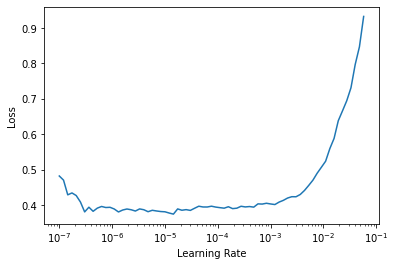

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500, step, freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.385246,0.367554,0.138733,00:29
1,0.408650,0.376155,0.123820,00:29


Better model found at epoch 0 with valid_loss value: 0.3675537109375.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,0.389628,0.369466,0.135043,00:32
1,0.425411,0.374992,0.127256,00:33
2,0.408024,0.369294,0.135956,00:33
3,0.415141,0.385267,0.126516,00:33
4,0.420511,0.377811,0.130124,00:34
5,0.424692,0.392807,0.133634,00:33


Better model found at epoch 0 with valid_loss value: 0.3694658875465393.
Better model found at epoch 2 with valid_loss value: 0.369293749332428.
Epoch 4: reducing lr to 1.1082922089570082e-08
No improvement since epoch 2: early stopping


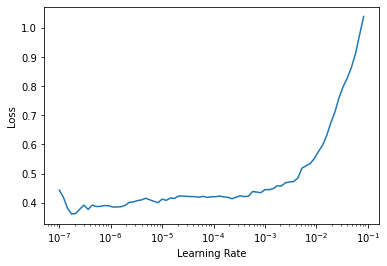

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500, step, freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.442913,0.377240,0.125288,00:30
1,0.428736,0.375539,0.123123,00:28


Better model found at epoch 0 with valid_loss value: 0.37724006175994873.
Better model found at epoch 1 with valid_loss value: 0.37553879618644714.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,0.436215,0.380809,0.140084,00:33
1,0.428906,0.386371,0.125706,00:33
2,0.428617,0.372725,0.127724,00:33
3,0.421833,0.366859,0.130628,00:33
4,0.430453,0.379611,0.125409,00:34
5,0.421575,0.382655,0.141450,00:32
6,0.408419,0.367351,0.137386,00:33


Better model found at epoch 0 with valid_loss value: 0.38080862164497375.
Better model found at epoch 2 with valid_loss value: 0.3727247416973114.
Better model found at epoch 3 with valid_loss value: 0.3668591380119324.
Epoch 5: reducing lr to 4.860740342437506e-08
No improvement since epoch 3: early stopping


In [ ]:
torch.save(model.state_dict(),'efficientdet.pth')

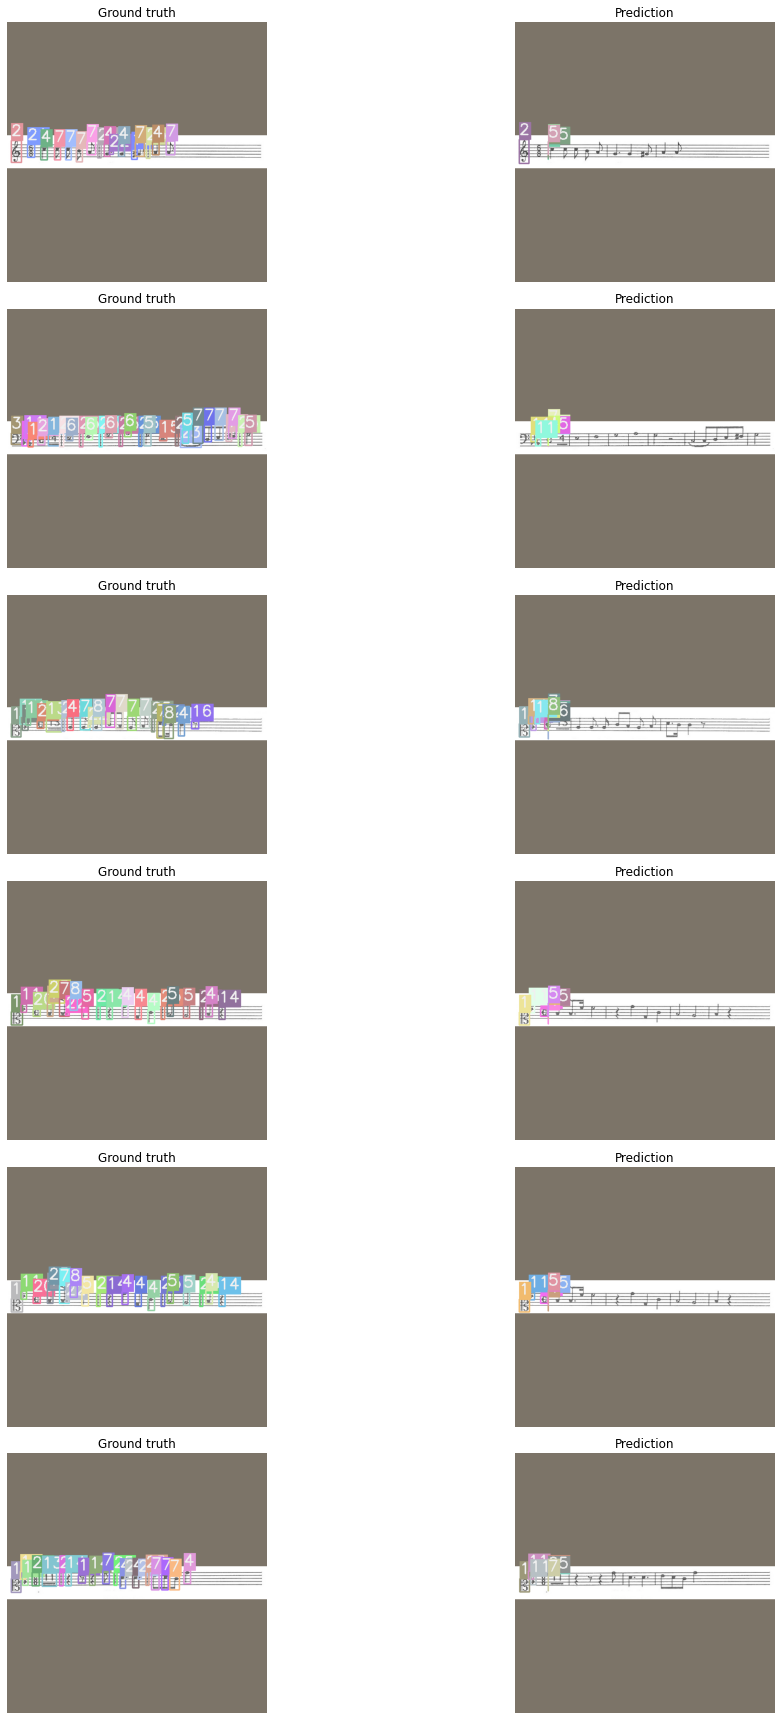

In [ ]:
efficientdet.show_results(model, valid_ds)

#### Inferencia en conjunto de test

In [ ]:
state_dict = torch.load('efficientdet.pth')
model = efficientdet.model(model_name="tf_efficientdet_d3", num_classes=35, img_size=size)

In [ ]:
model.load_state_dict(state_dict)

In [ ]:
test1=cv2.imread('/content/dataset/test/images/pent189.jpg')
test2=cv2.imread('/content/dataset/test/images/pent280.jpg')
test3=cv2.imread('/content/dataset/test/images/super_mario_theme7.jpg') # Esta funcionará peor ya que es de otra clase

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])
infer_ds = Dataset.from_images([test1,test2,test3], infer_tfms)
infer_dl = efficientdet.infer_dl(infer_ds, batch_size=1)
samples, preds = efficientdet.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

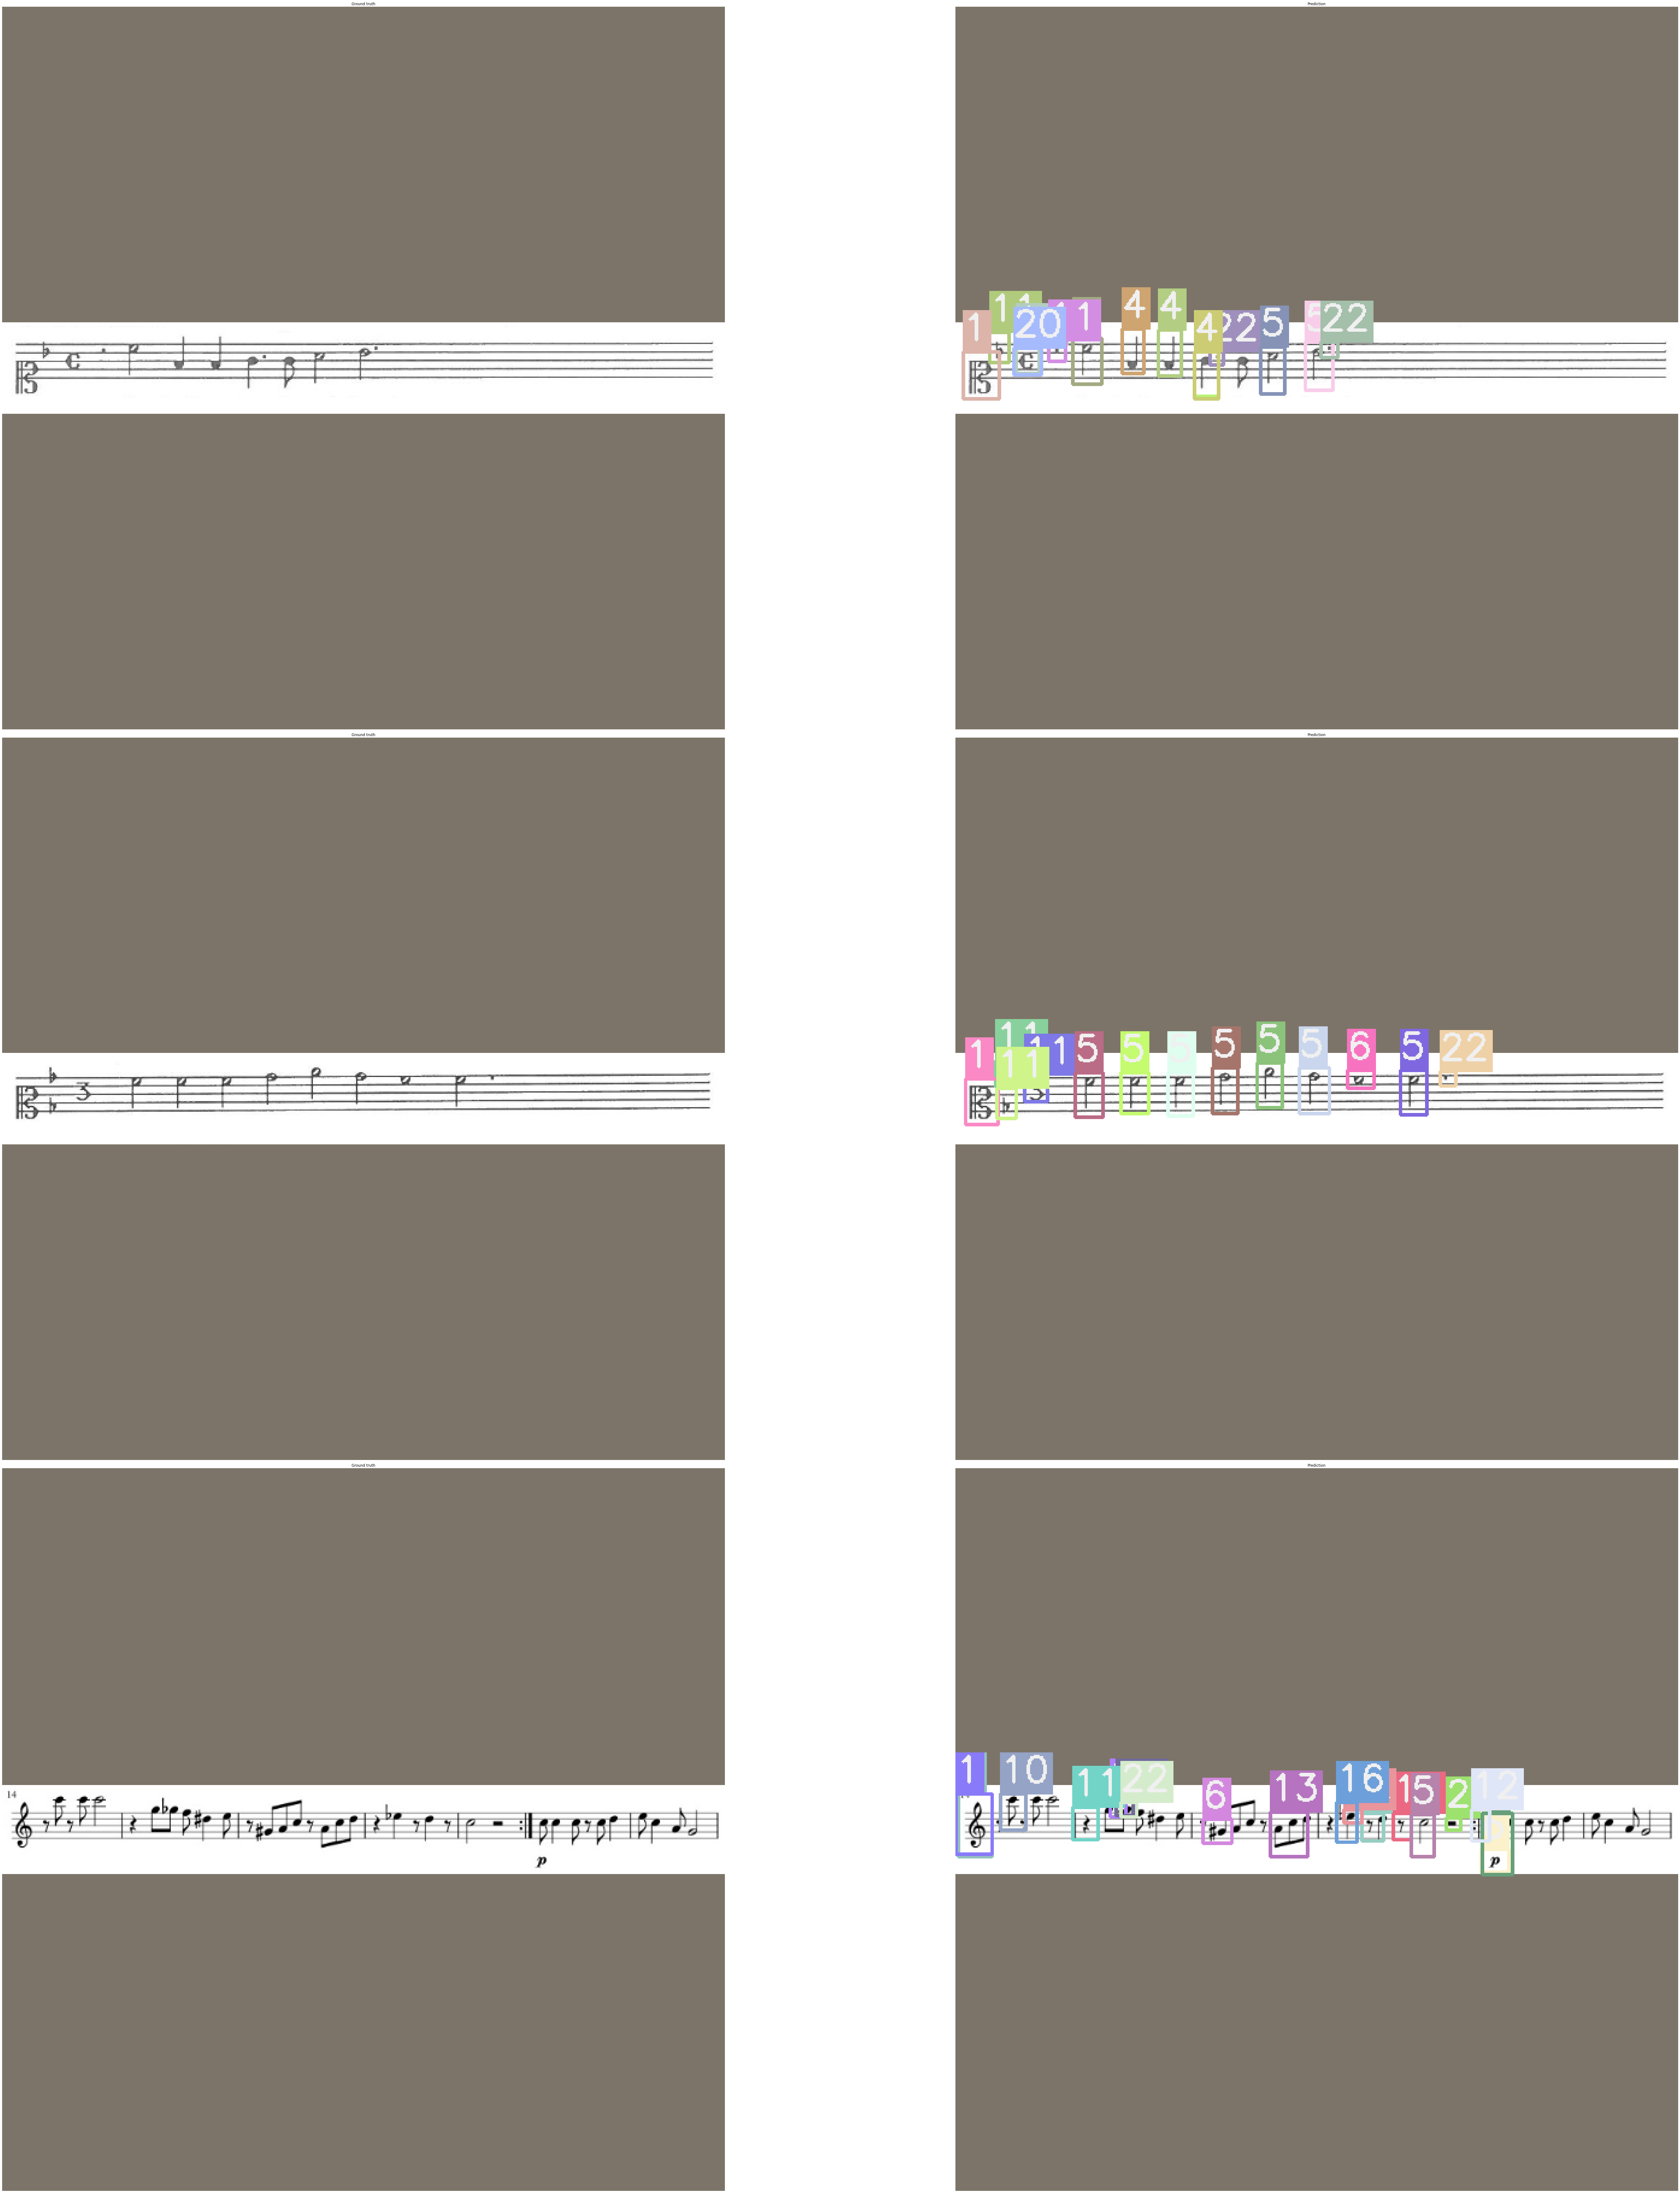

In [ ]:
show_preds(samples=samples, preds=preds,denormalize_fn=denormalize_imagenet,figsize=(100,100))

#### Resultado final en conjunto de test

In [ ]:
state_dict = torch.load('efficientdet.pth')
model = efficientdet.model(model_name="tf_efficientdet_d3", num_classes=35, img_size=size)

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

In [ ]:
test_ds = Dataset(test_rs, valid_tfms)
test_dl = efficientdet.valid_dl(test_ds, batch_size=2, num_workers=0, shuffle=False)

In [ ]:
newdl = fastai.DataLoaders(faster_rcnn.fastai.convert_dataloader_to_fastai(train_dl),faster_rcnn.fastai.convert_dataloader_to_fastai(test_dl)).to('cuda')

In [ ]:
learn.dls = newdl
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.1556851971563123.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.3708287477493286,0.1556851971563123]

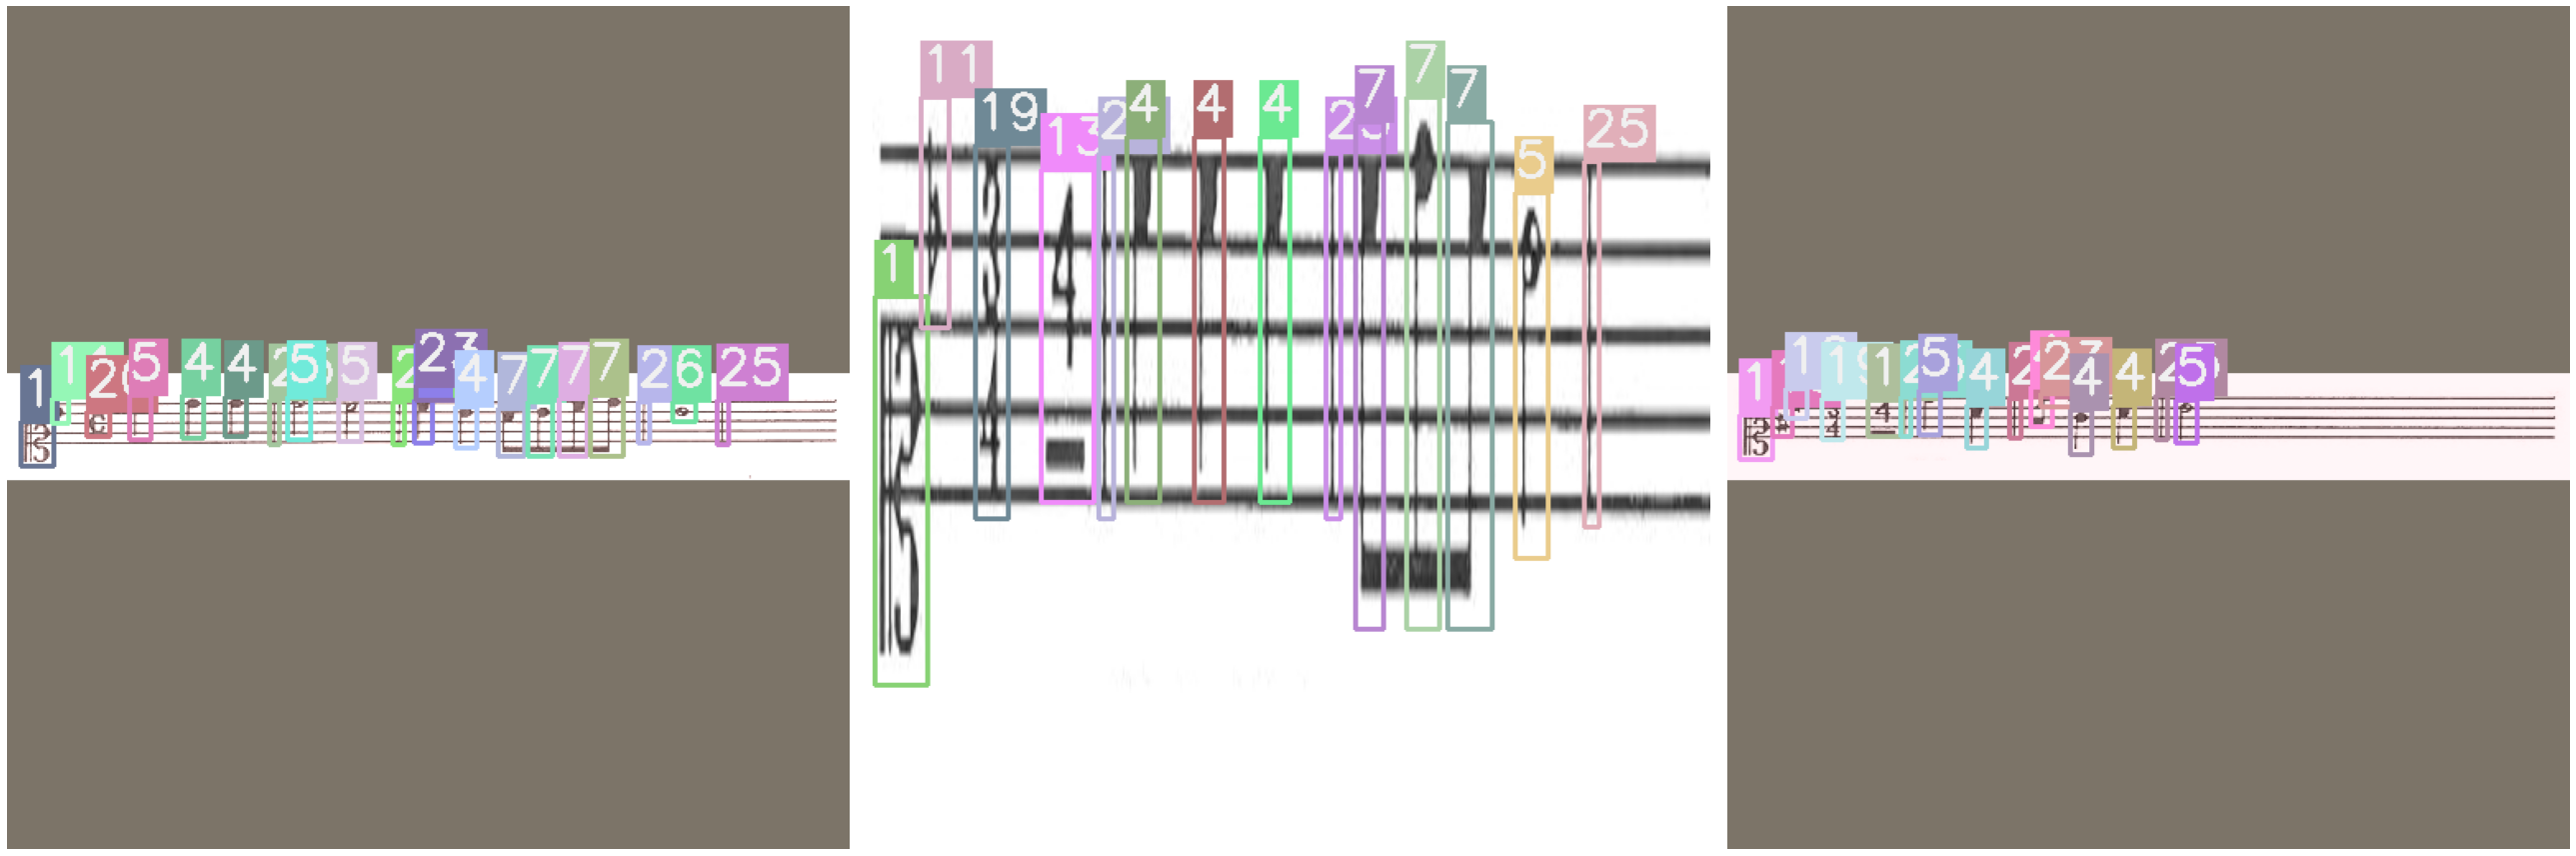

In [ ]:
samples = [newdl.dataset[i] for i in range(3)]
show_samples(samples, ncols=3,denormalize_fn=denormalize_imagenet)

- **COCO metric en conjunto de test: 0.156**

*   Elemento de lista
*   Elemento de lista



### RetinaNet

In [13]:
presize = 926
size = 926

In [14]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None, horizontal_flip=None), tfms.A.Normalize()])

In [15]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

In [16]:
train_dl = retinanet.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = retinanet.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)

In [23]:
callbacks = [EarlyStoppingCallback(patience=3),SaveModelCallback(fname='RetinaNet'),ReduceLROnPlateau(patience=2) ]

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [19]:
model = retinanet.model(num_classes=35)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

In [20]:
learn = retinanet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


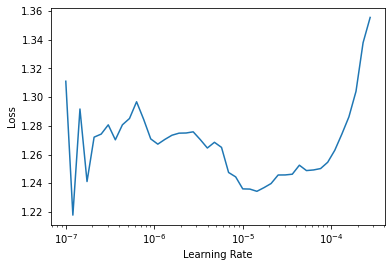

In [25]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500,step,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.276033,1.022609,0.005878,01:13
1,1.260465,1.020149,0.006258,01:11


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Better model found at epoch 0 with valid_loss value: 1.0226086378097534.
Better model found at epoch 1 with valid_loss value: 1.0201486349105835.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,1.248610,1.015792,0.006523,01:35
1,1.232665,1.015802,0.006330,01:33
2,1.241304,1.013529,0.006669,01:33
3,1.250767,1.011961,0.007000,01:33
4,1.241831,1.011136,0.007107,01:32
5,1.229349,1.010310,0.007170,01:33
6,1.236336,1.010888,0.007243,01:32
7,1.221654,1.008206,0.007539,01:32
8,1.222662,1.006834,0.007923,01:32
9,1.233994,1.005281,0.008470,01:32


Better model found at epoch 0 with valid_loss value: 1.0157922506332397.
Better model found at epoch 2 with valid_loss value: 1.0135290622711182.
Better model found at epoch 3 with valid_loss value: 1.0119611024856567.
Better model found at epoch 4 with valid_loss value: 1.0111359357833862.
Better model found at epoch 5 with valid_loss value: 1.010310411453247.
Better model found at epoch 7 with valid_loss value: 1.008205533027649.
Better model found at epoch 8 with valid_loss value: 1.0068343877792358.
Better model found at epoch 9 with valid_loss value: 1.0052810907363892.
Better model found at epoch 10 with valid_loss value: 1.0034278631210327.
Better model found at epoch 11 with valid_loss value: 1.0029573440551758.
Better model found at epoch 12 with valid_loss value: 1.0019922256469727.
Better model found at epoch 13 with valid_loss value: 0.9996843338012695.
Better model found at epoch 14 with valid_loss value: 0.9991393089294434.
Better model found at epoch 15 with valid_loss v

In [ ]:
learn.load('RetinaNet')

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500,step,freeze_epochs=2)

# FastAI (Clasificación de notas)

In [ ]:
%%capture
!pip install fastai --upgrade

In [ ]:
from fastai.vision.all import *

## Dataset

In [ ]:
%%capture
!unzip Musica.zip

In [ ]:
path = Path('Musica/notas/')

In [ ]:
path.ls()

(#17) [Path('Musica/notas/5'),Path('Musica/notas/13'),Path('Musica/notas/2'),Path('Musica/notas/3'),Path('Musica/notas/11'),Path('Musica/notas/-1'),Path('Musica/notas/4'),Path('Musica/notas/-2'),Path('Musica/notas/12'),Path('Musica/notas/1')...]

## Construyendo Datablock y Dataloader

In [ ]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize((256,64)),
                 batch_tfms=aug_transforms(size=(256,64),mult=1.0, do_flip=True, flip_vert=False, max_rotate=5.0, min_zoom=1.0, max_zoom=1.05, max_lighting=0.1, max_warp=0.1, p_affine=0.3))

In [ ]:
dls = db.dataloaders(path,bs=128)

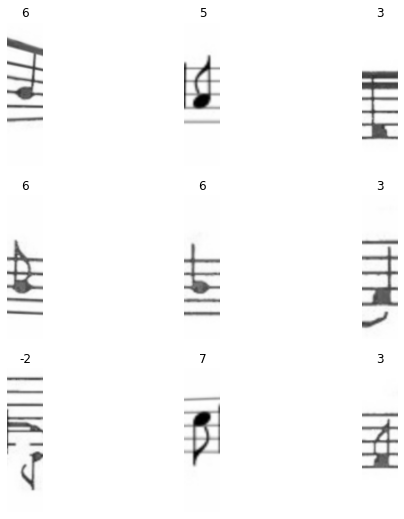

In [ ]:
dls.show_batch()

## Callbacks

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelResnet18')  
]

## Entrenamiento

In [ ]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.007585775572806597)

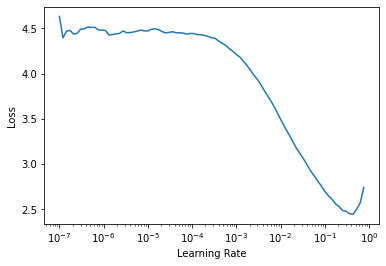

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.319837,3.854353,0.437376,00:04


Better model found at epoch 0 with valid_loss value: 3.854353427886963.


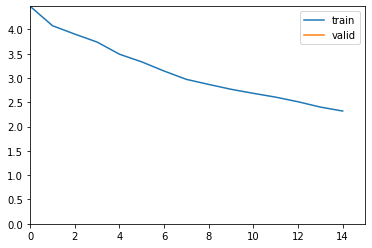

epoch,train_loss,valid_loss,accuracy,time
0,0.856993,0.886689,0.827038,00:04
1,0.502446,0.342009,0.922465,00:04
2,0.335272,0.123513,0.972167,00:04
3,0.240203,0.077614,0.982107,00:04
4,0.185965,0.056900,0.984095,00:04
5,0.144416,0.056058,0.984095,00:04
6,0.116194,0.100388,0.982107,00:04
7,0.096377,0.106435,0.974155,00:04
8,0.082472,0.149062,0.970179,00:04


Better model found at epoch 0 with valid_loss value: 0.8866886496543884.


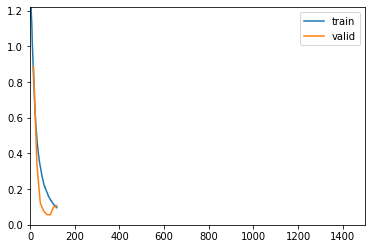

Better model found at epoch 1 with valid_loss value: 0.34200891852378845.
Better model found at epoch 2 with valid_loss value: 0.12351273000240326.
Better model found at epoch 3 with valid_loss value: 0.07761441916227341.
Better model found at epoch 4 with valid_loss value: 0.05689983442425728.
Better model found at epoch 5 with valid_loss value: 0.05605823174118996.
No improvement since epoch 5: early stopping


In [ ]:
learn.fine_tune(100, base_lr=4e-2)

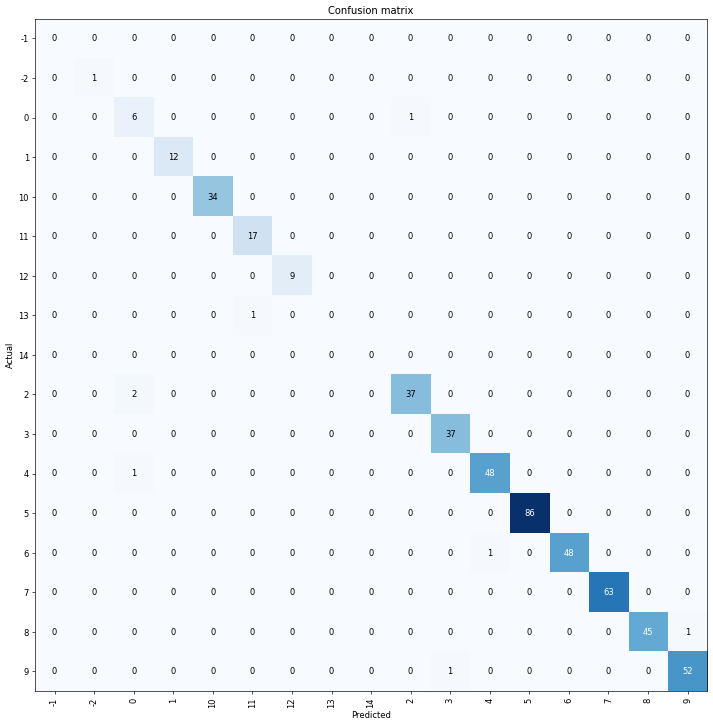

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.export()